<a href="https://colab.research.google.com/github/polisoma/DS4A/blob/master/Amazon_bestsellers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Getting dependancies**

In [1]:
import pandas as pd
import numpy as np
import missingno
!pip install fuzzywuzzy
!pip install python-Levenshtein
import fuzzywuzzy
from fuzzywuzzy import process
import collections
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

     |████████████████████████████████| 51kB 2.6MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149804 sha256=a1f9e3fc4c312c64db65dcdbafa4e6f12e4a333894a2f59a8416e6c35d7dcf45
  Stored in directory: /root/.cache/pip/wheels/b3/26/73/4b48503bac73f01cf18e52cd250947049a7f339e940c5df8fc
Successfully built python-Levenshtein


In [2]:
bestsellers=pd.read_csv('/content/drive/MyDrive/bestsellers with categories.csv')
bestsellers.head()

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction


# **loading the data and the first look**


f tells to interprete {} (similar to -en for echo)

In [ ]:
print(f'The table has {bestsellers.shape[0]} lines/records and {bestsellers.shape[1]} columns.')

The table has 550 lines/records and 7 columns.


In [ ]:
bestsellers.dtypes

Name            object
Author          object
User Rating    float64
Reviews          int64
Price            int64
Year             int64
Genre           object
dtype: object

Changing Genre from 'object' to 'category'. Category is a hybrid data type. It looks and behaves like a string in many instances but internally is represented by an array of integers. This allows the data to be sorted in a custom order and to more efficiently store the data

In [ ]:
bestsellers.Genre=bestsellers.Genre.astype('category')
bestsellers.dtypes

Name             object
Author           object
User Rating     float64
Reviews           int64
Price             int64
Year              int64
Genre          category
dtype: object

Calculating % of missing values per column. I am not sure it shows %... COuldn't find what .1% does

In [ ]:
for col in bestsellers.columns:
  best_missing=bestsellers[col].isnull().mean()
  print(f'{col} has {best_missing} on average and {best_missing : .1%}')

Name has 0.0 on average and  0.0% %
Author has 0.0 on average and  0.0% %
User Rating has 0.0 on average and  0.0% %
Reviews has 0.0 on average and  0.0% %
Price has 0.0 on average and  0.0% %
Year has 0.0 on average and  0.0% %
Genre has 0.0 on average and  0.0% %


Really cool and fast visualization for missing values

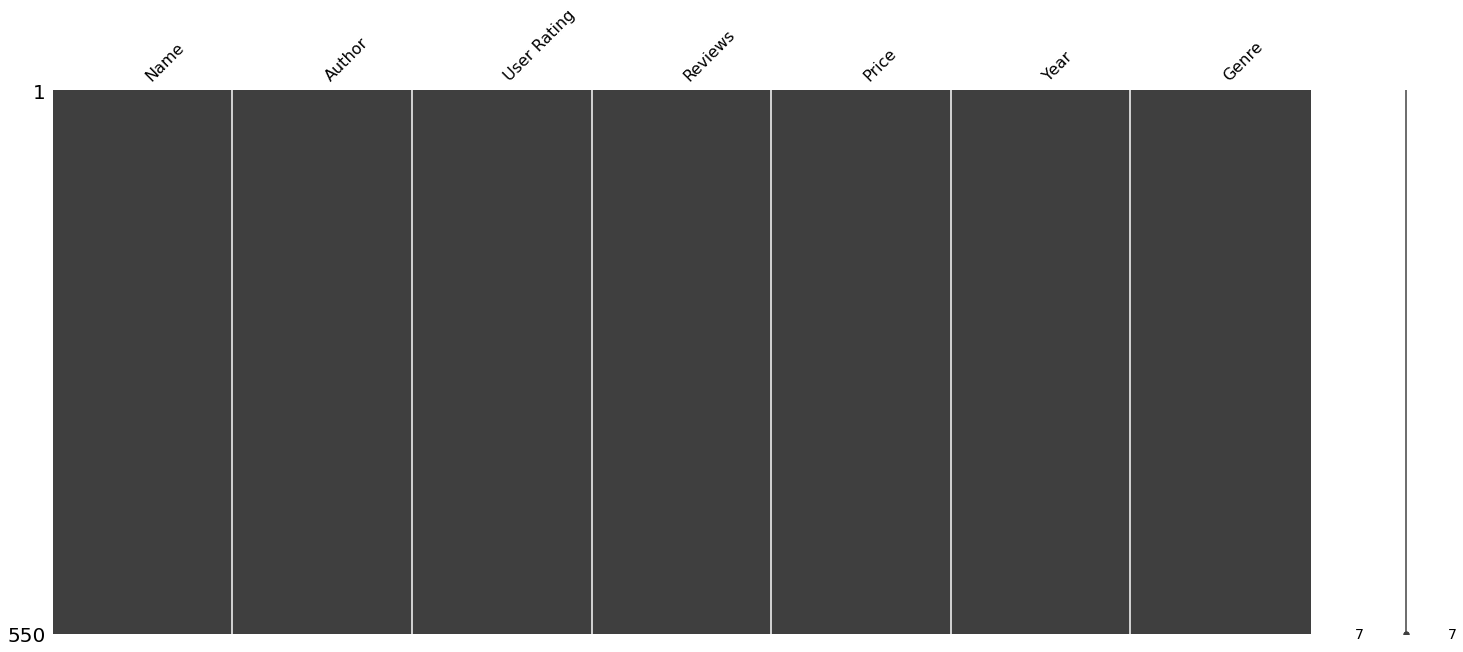

In [ ]:
# Build a matrix of missing values
missingno.matrix(bestsellers, fontsize = 16)
plt.show()

Getting misspelt values. Selecting columns not numbers

In [ ]:
col_names=list(bestsellers.select_dtypes(exclude=('float64','int64')).columns)
print(f'Сolumns without numeric data: {", ".join(col_names)}.')

Сolumns without numeric data: Name, Author, Genre.


checking duplicates

In [ ]:
for col in col_names:
  if bestsellers[col].duplicated().any() == True: 
    print (f'{col} has duplicates')
  else: print (f'{col} has no duplicates')

Name has duplicates
Author has duplicates
Genre has duplicates


getting misspelt items. What sort of typing errors? 
string.strip() - leading or trailing white spaces are removed. Python string method title() returns a copy of the string in which first characters of all the words are capitalized. Doesn't seem a robust way of finding typos...

In [ ]:
for col in col_names:
    print(f'Before {col}: {len(set(bestsellers[col]))} \
    After {col}: {len(set(bestsellers[col].str.title().str.strip()))}')

# Correct the errors (could have done it in the cleaning/loading part)
bestsellers.Name = bestsellers.Name.str.title().str.strip()

print('\nAfter cleaning\n')
for col in col_names:
    print(f'Before {col}: {len(set(bestsellers[col]))} \
    After {col}: {len(set(bestsellers[col].str.title().str.strip()))}')

Before Name: 350     After Name: 350
Before Author: 248     After Author: 248
Before Genre: 2     After Genre: 2

After cleaning

Before Name: 350     After Name: 350
Before Author: 248     After Author: 248
Before Genre: 2     After Genre: 2


how fuzzywuzzy.process.extract works
https://stackoverflow.com/questions/41171665/python-fuzzywuzzys-process-extract-how-does-it-work

token_sort_ratio: Measure of the sequences' similarity sorting the token before comparing.



Ideally: getting all authors names, run fuzzywuzzy, getting 100 matches and replacing them. In for loop. 

In [ ]:
# getting values that match George R.R. Martin
authors = bestsellers.Author.sort_values().unique()
matches_author_name = fuzzywuzzy.process.extract('George R.R. Martin', authors, limit=5, \
                                                 scorer=fuzzywuzzy.fuzz.token_sort_ratio)
matches_author_name

[('George R. R. Martin', 100),
 ('George R.R. Martin', 100),
 ('George Orwell', 53),
 ('Bill Martin Jr.', 52),
 ('Greg Mortenson', 52)]

In [3]:
bestsellers = bestsellers.replace('George R. R. Martin', 'George R.R. Martin')
bestsellers = bestsellers.replace('J. K. Rowling', 'J.K. Rowling')

In [ ]:
# Check the column Genre
genre = bestsellers.Genre.unique()
print('What is in Genre')
genre
# Check the column Year
print('What is in Years')
years = list(bestsellers.Year.unique())
sorted(years)

What is in Genre
What is in Years


[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

There are duplicated lines, but only year is different. It was visible by looking at the whole dataframe. For the future: how to spot it automatically. One way to deal with it is to remove all years. 

In [4]:
# Delete the year column
del bestsellers['Year']
# another way of doing it. (0 for rows and 1 for columns.)
# bestsellers.drop('Year', axis=1, inplace=True)
# df = df.drop(df.columns[[0, 1, 3]], axis=1)
# df.drop(['column_nameA', 'column_nameB'], axis=1, inplace=True)

In [5]:
# dropping duplicates
bestsellers = bestsellers.drop_duplicates(keep='first')
bestsellers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 546
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         361 non-null    object 
 1   Author       361 non-null    object 
 2   User Rating  361 non-null    float64
 3   Reviews      361 non-null    int64  
 4   Price        361 non-null    int64  
 5   Genre        361 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 19.7+ KB


we have 350 names of the books, but getting way more entries. Getting examples of multiplicated ones to further check what was wrong

collections.Counter()
A counter is a container that stores elements as dictionary keys, and their counts are stored as dictionary values.

In [ ]:
count_books = collections.Counter(bestsellers.Name.tolist())
print(count_books.most_common(11)) # very nice idea to look at most common!

[('The Help', 3), ('Gone Girl', 2), ("Quiet: The Power Of Introverts In A World That Can'T Stop Talking", 2), ('The 5 Love Languages: The Secret To Love That Lasts', 2), ('The 7 Habits Of Highly Effective People: Powerful Lessons In Personal Change', 2), ('The Fault In Our Stars', 2), ('The Girl On The Train', 2), ('The Immortal Life Of Henrietta Lacks', 2), ('To Kill A Mockingbird', 2), ('Unbroken: A World War Ii Story Of Survival, Resilience, And Redemption', 2), ('10-Day Green Smoothie Cleanse', 1)]


In [ ]:
bestsellers[bestsellers['Name'] == 'The Help']

,Name,Author,User Rating,Reviews,Price,Genre
402,The Help,Kathryn Stockett,4.8,13871,6,Fiction
404,The Help,Kathryn Stockett,4.8,13871,8,Fiction
405,The Help,Kathryn Stockett,4.8,13871,7,Fiction


Books had different price. Will keep only the most recent one. (we already deleted years... but keep='last')

In [6]:
# Drop duplicates
bestsellers = bestsellers.drop_duplicates(subset='Name', keep='last')
bestsellers

,Name,Author,User Rating,Reviews,Price,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,Non Fiction
...,...,...,...,...,...,...
538,Winter of the World: Book Two of the Century T...,Ken Follett,4.5,10760,15,Fiction
539,Women Food and God: An Unexpected Path to Almo...,Geneen Roth,4.2,1302,11,Non Fiction
540,Wonder,R. J. Palacio,4.8,21625,9,Fiction
545,Wrecking Ball (Diary of a Wimpy Kid Book 14),Jeff Kinney,4.9,9413,8,Fiction


In [10]:
# saving a clean dataset that I can load in the future
from google.colab import files
bestsellers.to_csv('/content/drive/MyDrive/bestsellers_clean.csv') 
#files.download('filename.csv')

**CONCLUSION: 350 different books by 246 authors. two categories (Non Fiction, Fiction).** 

# More interesting questions

In [14]:
from google.colab import files
# bestsellers.to_csv('/content/drive/MyDrive/bestsellers_clean.csv') 
bestsellers_clean=pd.read_csv('/content/drive/MyDrive/bestsellers_clean.csv')
bestsellers_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   351 non-null    int64  
 1   Name         351 non-null    object 
 2   Author       351 non-null    object 
 3   User Rating  351 non-null    float64
 4   Reviews      351 non-null    int64  
 5   Price        351 non-null    int64  
 6   Genre        351 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 19.3+ KB
